In [1]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, classification_report

# Task 1: Linear Regression with Stochastic Gradient Descent (SGD)

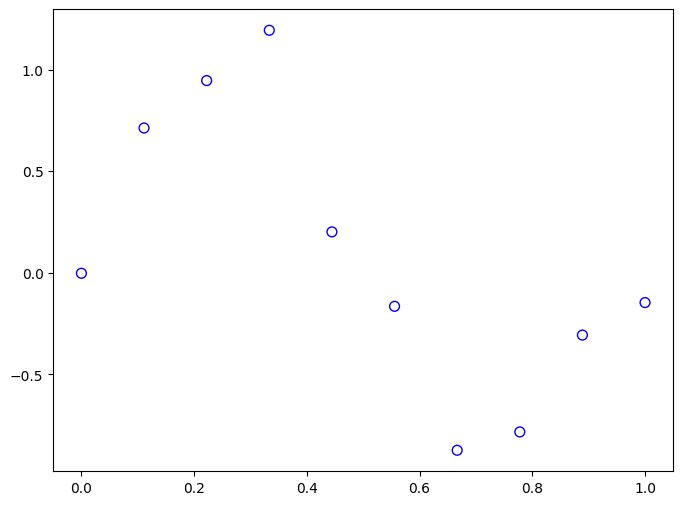

In [2]:
# Creating the dataset and plotting the training data

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = torch.linspace(domain[0], domain[1], sample_size)
    x = x[torch.randperm(sample_size)]
    y = func(x) + torch.normal(mean = 0, std=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return torch.sin(2 * torch.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = torch.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

plt.figure(figsize=[8,6])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")

#### Equations for SGD:-

1. Model Hypothesis
$$ h(x^{(i)}) = w_1 x^{(i)} + w_2 (x^{(i)})^2 + \dots + w_n (x^{(i)})^n + b $$

2. Mean Squared Error (MSE) Loss
$$ L(w, b) = \frac{1}{m} \left( y^{(i)} - h(x^{(i)}) \right)^2 $$

3. MSE Loss with L2 Regularization
$$ L_{\text{MSE + L2}}(w, b) = \frac{1}{N} \sum_{i=1}^{N} \left( h(x^{(i)}) - y^{(i)} \right)^2 + \lambda \sum_{j=1}^{d} w_j^2 $$

4. Gradient of the Loss w.r.t Weights
$$ \frac{\partial L}{\partial w_j} = \left( h(x^{(i)}) - y^{(i)} \right) x^{(i)j} $$

5. Gradient of the Loss w.r.t Bias
$$ \frac{\partial L}{\partial b} = \left( h(x^{(i)}) - y^{(i)} \right) $$

6. Update Rule
$$ w_j := w_j - \alpha \frac{\partial L}{\partial w_j} $$
$$ b := b - \alpha \frac{\partial L}{\partial b} $$

7. Final SGD Equations
$$ w_j := w_j - \alpha \left( h(x^{(i)}) - y^{(i)} \right) x^{(i)j} $$
$$ b := b - \alpha \left( h(x^{(i)}) - y^{(i)} \right) $$


In [3]:
# Helper functions for SGD

def polynomial_features(x, degree):
    return torch.stack([x ** i for i in range(1, degree + 1)], dim=1)

def regression_model(x_poly, weights, bias):
    return x_poly @ weights + bias

# Mean Squared Error (MSE) loss function
def mse(y_pred, y_true):
    return ((y_true - y_pred) ** 2).mean()

def mse_with_l2_regularization(y_pred, y_true, regularization_lambda, weights):
    mse = ((y_pred - y_true) ** 2).mean()
    reg_loss = regularization_lambda * (weights ** 2).sum()
    return mse + reg_loss



In [4]:
# Transform the training data to include polynomial features up to x^9

degree = 9
x_train_poly = polynomial_features(x_train, degree)

weights = torch.randn(degree, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

learning_rate = 0.01
epochs = 200000
loss_threshold = 1e-10
losses = []
regularization_lambda = 0.01
converged_epoch = None

# Stochastic Gradient Descent with loss threshold
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(x_train_poly)):
        x_i = x_train_poly[i]
        y_i = y_train[i]

        y_pred = regression_model(x_i, weights, bias)
        loss = mse_with_l2_regularization(y_pred, y_i, regularization_lambda, weights)
        epoch_loss += loss.item()
        loss.backward()
        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad

        weights.grad.zero_()
        bias.grad.zero_()

    epoch_loss /= len(x_train_poly)
    losses.append(epoch_loss)

    if epoch > 0 and abs(losses[-1] - losses[-2]) < loss_threshold:
        converged_epoch = epoch + 1
        print(f'Converged at epoch {converged_epoch} due to small loss improvement')
        break

# Final model parameters
print(f'Final loss: {losses[-1]}')
print(f'Final weights: {weights.detach().tolist()}')
print(f'Final bias: {bias.item()}')


Converged at epoch 2582 due to small loss improvement
Final loss: 0.21363762617111207
Final weights: [-0.3253396451473236, -1.1879167556762695, -0.8310715556144714, -0.3363627791404724, 0.03275102376937866, 0.2879658043384552, 0.438790500164032, 0.5209000110626221, 0.5606895685195923]
Final bias: 0.6558657884597778


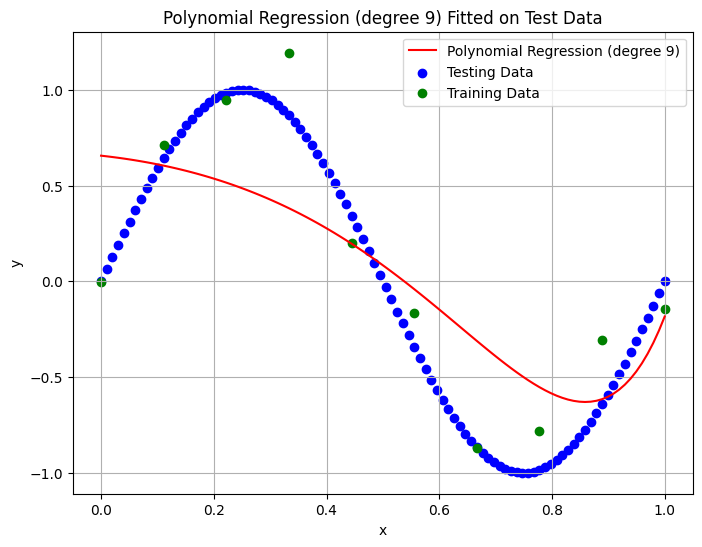

In [5]:

y_train_pred = (x_train_poly @ weights.detach()) + bias.detach()
x_test_poly = polynomial_features(x_test,degree)
y_test_pred = (x_test_poly @ weights.detach()) + bias.detach()

plt.figure(figsize=(8, 6))

sorted_test_indices = x_test.argsort()
x_test_sorted = x_test[sorted_test_indices]
y_test_sorted = y_test_pred[sorted_test_indices]

plt.plot(x_test_sorted.numpy(), y_test_sorted.numpy(), label="Polynomial Regression (degree 9)", color='r')
plt.scatter(x_test.numpy(), y_test.numpy(), label="Testing Data", color='b')
plt.scatter(x_train.numpy(), y_train.numpy(), label="Training Data", color='g')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression (degree 9) Fitted on Test Data')
plt.legend()
plt.grid(True)
plt.show()

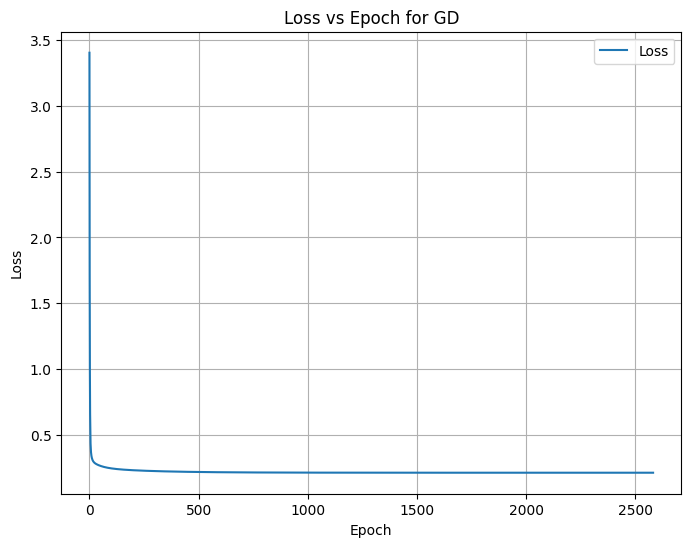

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(losses, label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for GD')
plt.legend()
plt.grid(True)
plt.show()

Converged at epoch 70841 due to small loss improvement


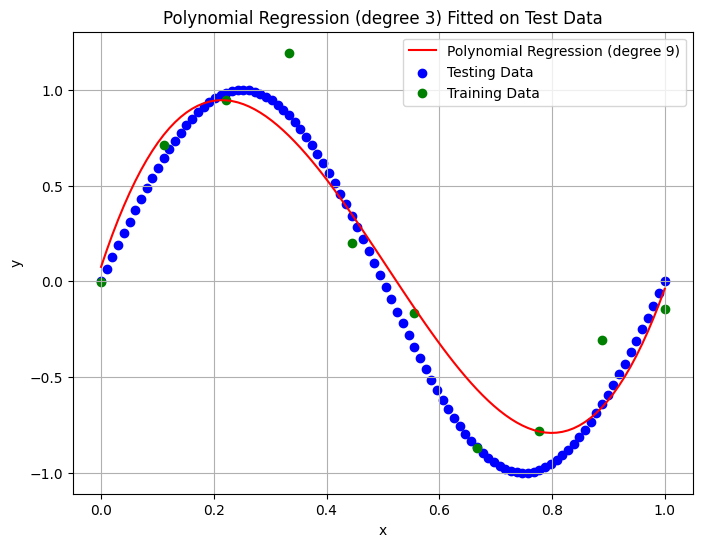

In [7]:
degree = 3
x_train_poly = polynomial_features(x_train, degree)

weights = torch.randn(degree, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

learning_rate = 0.01
epochs = 200000
loss_threshold = 1e-10
losses = []
regularization_lambda = 0.01
converged_epoch = None

# Stochastic Gradient Descent with loss threshold
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(x_train_poly)):
        x_i = x_train_poly[i]
        y_i = y_train[i]

        y_pred = regression_model(x_i, weights, bias)
        loss = mse(y_pred, y_i)
        epoch_loss += loss.item()
        loss.backward()
        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad

        weights.grad.zero_()
        bias.grad.zero_()

    epoch_loss /= len(x_train_poly)
    losses.append(epoch_loss)

    if epoch > 0 and abs(losses[-1] - losses[-2]) < loss_threshold:
        converged_epoch = epoch + 1
        print(f'Converged at epoch {converged_epoch} due to small loss improvement')
        break

y_train_pred = (x_train_poly @ weights.detach()) + bias.detach()
x_test_poly = polynomial_features(x_test,degree)
y_test_pred = (x_test_poly @ weights.detach()) + bias.detach()

plt.figure(figsize=(8, 6))

sorted_test_indices = x_test.argsort()
x_test_sorted = x_test[sorted_test_indices]
y_test_sorted = y_test_pred[sorted_test_indices]

plt.plot(x_test_sorted.numpy(), y_test_sorted.numpy(), label="Polynomial Regression (degree 9)", color='r')
plt.scatter(x_test.numpy(), y_test.numpy(), label="Testing Data", color='b')
plt.scatter(x_train.numpy(), y_train.numpy(), label="Training Data", color='g')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression (degree 3) Fitted on Test Data')
plt.legend()
plt.grid(True)
plt.show()

#### Hyperparameters Used:
1) Learning Rate: Set to 0.01. The learning rate controls how much the model's weights are adjusted in each iteration.
2) Degree of Polynomial: Polynomial regression of degree 9, meaning the model fits a 9th-degree polynomial to the data.
3) Number of Epochs: Set to 1000. This is the maximum number of epochs, although early stopping may terminate training before this limit.
4) Loss Threshold: Early stopping is triggered if the loss becomes less than 0.00001. This ensures the algorithm stops once a sufficiently low loss is achieved.
5) Loss Function: Mean Squared Error (MSE) is used to measure the difference between the predicted and actual values.

Task 1; Part B - SGD using Momentum Algorithm


#### Equations for SGD with Momentum:
 Momentum Terms
Velocity for Weights:
$$ v_{w_j}^{(t)} = \beta v_{w_j}^{(t-1)} + (1 - \beta) \frac{\partial L}{\partial w_j} $$
Velocity for Bias:
$$ v_b^{(t)} = \beta v_b^{(t-1)} + (1 - \beta) \frac{\partial L}{\partial b} $$

Final Equations for SGD with Momentum
$$ v_{w_j}^{(t)} = \beta v_{w_j}^{(t-1)} + (1 - \beta) \frac{\partial L}{\partial w_j} $$
$$ v_b^{(t)} = \beta v_b^{(t-1)} + (1 - \beta) \frac{\partial L}{\partial b} $$
$$ w_j := w_j - \alpha v_{w_j}^{(t)} $$
$$ b := b - \alpha v_b^{(t)} $$


Converged at epoch 42371 due to small loss improvement


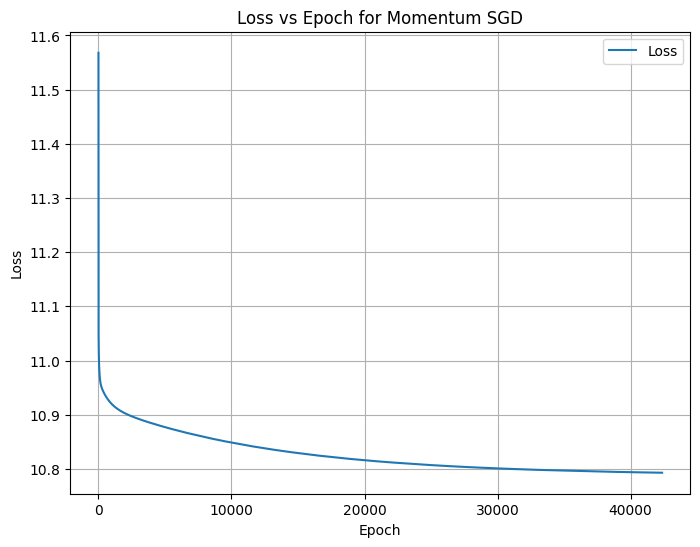

In [8]:

degree = 9
x_train_poly = polynomial_features(x_train, degree)

w = torch.randn(degree, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# Learning rate and momentum hyperparameters
learning_rate = 0.01
momentum = 0.9

w_momentum = torch.zeros_like(w)
b_momentum = torch.zeros_like(b)

epochs = 250000
loss_threshold = 1e-10
losses = []
regularization_lambda = 0.01

# Momentum SGD implementation
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(x_train_poly)):
        x_i = x_train_poly[i]
        y_i = y_train[i]
        y_pred = (x_i @ w) + b
        loss = mse_with_l2_regularization(y_pred, y_i, regularization_lambda, weights)
        epoch_loss += loss.item()
        loss.backward()

        with torch.no_grad():
            w_momentum = momentum * w_momentum + (1 - momentum) * w.grad
            b_momentum = momentum * b_momentum + (1 - momentum) * b.grad

            w -= learning_rate * w_momentum
            b -= learning_rate * b_momentum

            w.grad.zero_()
            b.grad.zero_()

    epoch_loss /= len(x_train_poly)
    losses.append(epoch_loss)

    if epoch > 0 and abs(losses[-1] - losses[-2]) < loss_threshold:
        converged_epoch = epoch + 1
        print(f'Converged at epoch {converged_epoch} due to small loss improvement')
        break


plt.figure(figsize=(8, 6))
plt.plot(losses, label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Momentum SGD')
plt.legend()
plt.grid(True)
plt.show()


#### Hyperparameters Used:
1) Learning Rate: Set to 0.01. The learning rate controls how much the model's weights are adjusted in each iteration.
2) Degree of Polynomial: Polynomial regression of degree 9, meaning the model fits a 9th-degree polynomial to the data.
3) Number of Epochs: Set to 1000. This is the maximum number of epochs, although early stopping may terminate training before this limit.
4) Loss Threshold: Early stopping is triggered if the loss becomes less than 0.00001. This ensures the algorithm stops once a sufficiently low loss is achieved.
5) Loss Function: Mean Squared Error (MSE) is used to measure the difference between the predicted and actual values.
6) Momentum Parameter: Set to 0.9. Momentum helps the gradient descent algorithm converge faster by accumulating past gradients to smooth out updates and avoid oscillations.

# Task 2: Logistic Regression

In [11]:
# Chunking the dataset and reading random rows from first n chunks
import random

samples = 100000
chunksize = 50000

reader = pd.read_csv("train.csv", chunksize=chunksize)

out = []
total = 0
for df in reader:
    nsample = random.randint(1,10000)
    total += nsample
    if  total > samples:
        nsample = samples - (total - nsample)
    out.append(df.sample(nsample))
    if total >= samples:
        break

df = pd.concat(out)

In [12]:
print(df.nunique())

cols_to_drop = ["id","hour","device_ip","device_id","device_model","app_id","site_id","site_domain","C14","C17"]
df = df.drop(cols_to_drop, axis=1)

id                  100000
click                    2
hour                     5
C1                       7
banner_pos               6
site_id               1130
site_domain            969
site_category           19
app_id                1082
app_domain              74
app_category            22
device_id            12344
device_ip            62799
device_model          2890
device_type              4
device_conn_type         4
C14                    480
C15                      7
C16                      8
C17                    150
C18                      4
C19                     39
C20                    150
C21                     35
dtype: int64


In [13]:
encoder = OneHotEncoder(sparse_output=False)
cols_to_encode = df.columns[1:]
print(cols_to_encode)
encoded_data = encoder.fit_transform(df[cols_to_encode])
encoded_df = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out(cols_to_encode))
print(encoded_df.columns)

Index(['C1', 'banner_pos', 'site_category', 'app_domain', 'app_category',
       'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C19', 'C20',
       'C21'],
      dtype='object')
Index(['C1_1001', 'C1_1002', 'C1_1005', 'C1_1007', 'C1_1008', 'C1_1010',
       'C1_1012', 'banner_pos_0', 'banner_pos_1', 'banner_pos_2',
       ...
       'C21_95', 'C21_100', 'C21_101', 'C21_111', 'C21_112', 'C21_116',
       'C21_117', 'C21_156', 'C21_157', 'C21_195'],
      dtype='object', length=379)


In [14]:
x = encoded_df
y = df[["click"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
x_train_tensor = torch.tensor(x_train.values, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

#### Preprocessing steps and enhancements:-
1. Sampled the initial dataset by chunking and picking random points from the original CSV file instead of top k rows.
2. Dropped columns that contained >150 unique features for one hot encoding.
3. Performed One Hot Encoding of all the categorical features
4. Split into test train split of 80-20 ratio
5. Converted the pandas dataframe into pytorch tensors

#### Logistic Regression Equations with Stochastic Gradient Descent

1. Logistic Function:

\begin{equation}
    h_{\theta}(x^{(i)}) = \sigma(\theta^T x^{(i)}) = \frac{1}{1 + e^{-\theta^T x^{(i)}}}
\end{equation}

2. Binary Cross-Entropy Loss (Cost Function):

\begin{equation}
    J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h_{\theta}(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)})) \right]
\end{equation}

3. Gradient of the Loss with Respect to Parameters:

\begin{equation}
    \nabla J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right) x^{(i)}
\end{equation}

4. Stochastic Gradient Descent (SGD) Update Rule:

      In SGD, instead of summing over all \(m\) examples, we update the parameters after computing the gradient for each sample. The update rule for one sample \(x^{(i)}\) is:

\begin{equation}
    \theta := \theta - \alpha \left( h_{\theta}(x^{(i)}) - y^{(i)} \right) x^{(i)}
\end{equation}


5. Decision Boundary:

      The decision boundary for logistic regression is defined as:

\begin{equation}
    h_{\theta}(x) \geq 0.5 \implies \text{predict } 1
\end{equation}

\begin{equation}
    h_{\theta}(x) < 0.5 \implies \text{predict } 0
\end{equation}



In [16]:
# Helper Functions

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def bce(y_pred, y_true):
    epsilon = 1e-9  # Add epsilon to avoid log(0)
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

def sgd(params, lr):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

def accuracy(y_pred, y_true):
    predicted_labels = (y_pred >= 0.5).float()
    correct = (predicted_labels == y_true).float().sum()
    return correct / y_true.shape[0]

In [18]:
weights = torch.randn(x_train.columns.size, 1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

learning_rate = 0.01
num_epochs = 5

for epoch in range(num_epochs):
    epoch_loss = 0
    for i in range(x_train.shape[0]):
        x_i = x_train_tensor[i].unsqueeze(0)
        y_i = y_train_tensor[i].unsqueeze(0)
        z = x_i @ weights + bias
        y_pred = sigmoid(z)
        loss = bce(y_pred, y_i)
        epoch_loss += loss.item()
        loss.backward()
        sgd([weights, bias], learning_rate)

    epoch_loss /= (x_train_tensor.shape[0])
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/5], Loss: 0.4338
Epoch [2/5], Loss: 0.4152
Epoch [3/5], Loss: 0.4126
Epoch [4/5], Loss: 0.4112
Epoch [5/5], Loss: 0.4103


In [19]:
with torch.no_grad():
    z_test = x_test_tensor @ weights + bias
    y_pred_test = sigmoid(z_test)
    predicted_labels = (y_pred_test >= 0.5).float()

    test_accuracy = accuracy(y_pred_test, y_test_tensor)
    precision = precision_score(y_test_tensor, predicted_labels)
    recall = recall_score(y_test_tensor, predicted_labels)
    print(f'Test Accuracy: {test_accuracy.item() * 100:.2f}%')

Test Accuracy: 83.34%


In [20]:
print(classification_report(y_test_tensor, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91     16716
         1.0       0.48      0.16      0.24      3284

    accuracy                           0.83     20000
   macro avg       0.67      0.56      0.57     20000
weighted avg       0.79      0.83      0.80     20000



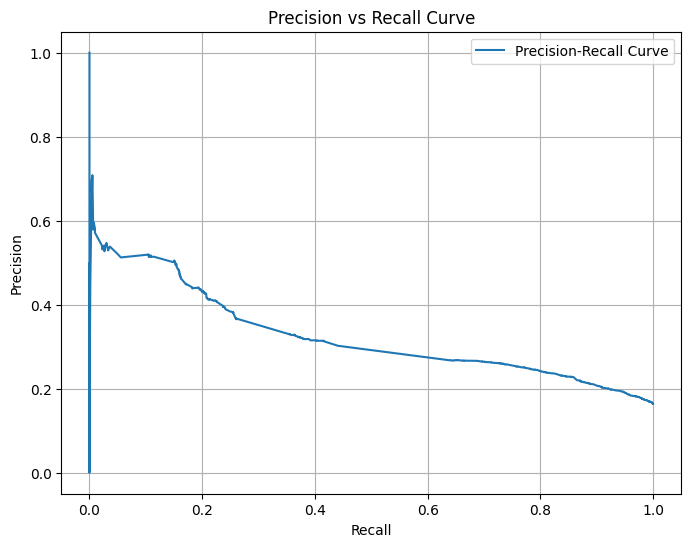

In [21]:
y_test_np = y_test_tensor.numpy()
y_pred_test_np = y_pred_test.numpy()

precisions, recalls, thresholds = precision_recall_curve(y_test_np, y_pred_test_np)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()